# 뉴스기사 요약하기  
뉴스 기사 데이터를 사용해 추상적 요약과 추출적 요약을 모두 해보기  
추상적 요약을 하는 경우 text는 본문, headlines는 요약 데이터가 됨  
추출적 요약을 하는 경우 text만 사용  
  
<b>전체 과정</b>  
step1. 데이터 수집  
step2. 데이터 전처리하기(추상적 요약)  
step3. 어텐션 메커니즘 사용하기(추상적 요약)  
step4. 실제 결과와 요약문 비교하기(추상적 요약)  
step5. Summa을 이용해 추출적 요약해보기  

In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#데이터 다운로드 
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


전체 샘플수 98401개이고 이는 이전 실습의 십만개 보다 적은 양이므로 그래도 사용하기로 결정했다.  

In [3]:
data.sample(10)

,headlines,text
43837,How did Hawking communicate despite motor neur...,World-renowned physicist Stephen Hawking gradu...
39785,18-yr-old becomes UK's youngest convicted fema...,"An 18-year-old woman, Safaa Boular, has become..."
7735,World Bank to raise $200 billion to fight clim...,The World Bank Group on Monday said it will do...
94516,Why're people questioning Akshay's N'tnl award...,Chairperson of National Film Awards jury Priya...
37303,Startup unveils world's 1st burger restaurant ...,US-based startup Creator has unveiled a robot-...
73627,Stalker chops off 15-yr-old girl's hand for re...,A 15-year-old girl's hand was allegedly cut of...
23458,WhatsApp Pay can't launch in India without off...,The government has clarified that WhatsApp can...
35651,"Caught 29 leakers, 12 of those arrested in 201...",In a recently revealed memo warning employees ...
4551,I waited for 8-9 months to be part of Kapil Sh...,Comedian Bharti Singh has revealed she waited ...
37145,"After Sachin, Kohli says two new balls 'brutal...",After cricketing legend Sachin Tendulkar slamm...


### 데이터 전처리하기(추상적 요약)  
step1. 중복 제거  
step2. null 값 제거  
step3. 텍스트 정규화 사전과 불용어 사전을 만들고 전처리 함수를 통해 text와 summary 데이터를 전처리 해준다.  

#### step1. 중복 제거 

In [4]:
#중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
#text 데이터에 중복 있으면 제거 
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### step2. null 값 제거 

In [6]:
#null 값 없음 
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### step3. 텍스트 정규화, 불용어, 전처리 함수 

In [7]:
#텍스트 정규화 사전 만들기 
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

headlines에 불용어를 처리해줄지 결정하기 위해 글자수 평균을 내고 이와 text의 평균 글자수를 비교했다.  
headlines의 평균 글자수는 57이고 text의 글자수는 357로 차이가 꽤 나기 때문에 headlines는 불용어 삭제 처리를 하지 않았다.  

In [9]:
#headlines와 text의 평균 글자수 비교 
headline_sum = 0
for headline in data['headlines']:
    headline_sum += len(str(headline))

headline_avg = headline_sum // 98360

text_sum = 0
for text in data['text']:
    text_sum += len(str(text))
    
text_avg = text_sum // 98360  

print("headlines 평균 글자 수:", headline_avg)
print("text 평균 글자 수:", text_avg)

headlines 평균 글자 수: 57
text 평균 글자 수: 357


이전에 실습했던 아마존 리뷰 데이터와는 달리 신문기사의 경우 형식적인 글이므로 "ummmmmm" 같은 비형식적인 단어는 없을거라 생각하여 이런 부분에 관해서 별도의 전처리를 하지 않았다.  

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    #sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

### 훈련 데이터 전체 전처리(추상적 요약)   
step1. 전처리 함수 처리  
step2. 훈련 데이터와 테스트 데이터 나누기  
-샘플 최대 길이 정하기  
-데이터분포 시각화  
-headlines에 시작 토큰과 종료 토큰 추가(시작토큰 sostoken, 종료토큰:eostoken)  

In [11]:
#text 데이터 전처리 
clean_text = []
 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
#headlines 전처리
clean_headlines = []
 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
#데이터 프레임에 재저장
data['text'] = clean_text 
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

#null 몇 개인지 확인 
data.isnull().sum() 

headlines    0
text         0
dtype: int64

In [14]:
#null 값 제거 
data.dropna(axis=0, inplace=True)  
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


전처리 함수를 거치기 이전의 글자수 평균은 headlines는 57이고 text의 글자수는 357이었다.  
전처리 함수를 거친 후 글자수 평균은 headlines는 9.299532330215534이고 text의 평균 글자수는 35.09968483123221로 확연히 줄여듦을 확인했다.  

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


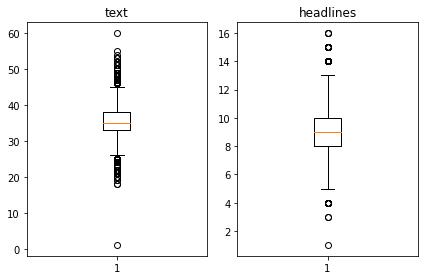

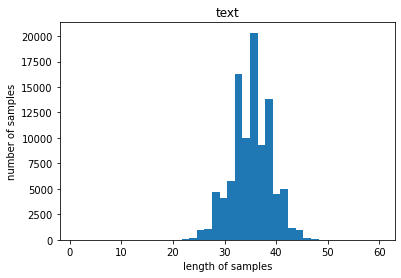

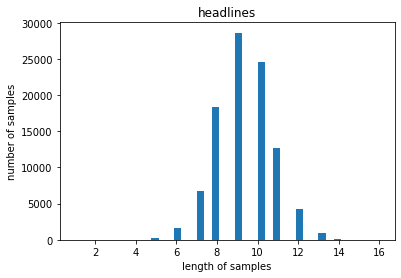

In [15]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

신문 기사는 text의 맨 앞과 맨 뒤에 핵심 문장이 있을 가능성이 있어 최대 깋이를 그대로 사용했다.  
신문 기사의 제목은 리뷰 summary와 다르게 완전한 문장 형식일 가능성이 높아 자르지 않고 그대로 포함시키기로 했다.  

In [16]:
#최대 길이 임의로 정하기
#데이터가 그리 긴 길이가 아니라서 최대 길이를 그대로 사용했다. 
text_max_len = 60
headlines_max_len = 16

In [18]:
#시작 토큰과 종료 토큰 추가 
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


<b>encoder와 decoder 정의</b>

In [19]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) #디코더의 레이블

In [20]:
#encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56932 25078 94472 ... 38822 82194 95025]


In [21]:
#데이터 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

<b>훈련 데이터와 테스트 데이터를 8:2로 분리</b>

In [22]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [23]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


<b>훈련 데이터에 대한 단어집합 만들기</b>  
src_tokenizer.word_counts.items():단어와 각 단어의 등장 빈도수가 저장  
src_tokenizer.word_index:입력 데이터에 대한 단어 집합과 각 단어에 대한 고유한 정수 저장  
tar_tokenizer.word_index:레이블 단어 집합과 각 단어에 대한 고유한 정수 저장  
texts_to_sequences():단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어를 모두 정수로 변환하는 정수 인코딩 수행  
num_words 값 정해주면 단어 집합 크기 제한  

In [24]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

<b>빈도수 낮은 단어들은 훈련 데이터에서 제외</b>  
빈도수 7회 미만인 단어는 단어 집합에서 68%이상 차지  
등장 빈도로 차지하는 비중 3.4% 밖에 되지 않음  


In [25]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69775
등장 빈도가 6번 이하인 희귀 단어의 수: 47579
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22196
단어 집합에서 희귀 단어의 비율: 68.18917950555357
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4869238094203605


In [26]:
#등장 빈도 6회 이하인 단어 정수 인코딩에서 제외,
#단어 집합 8000 크기로 제한 
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [27]:
#텍스트 시퀀스를 정수 시퀀스로 변환 
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

<b>headlines도 동일하게 단어집합과 정수 인코딩하기</b>

In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30037
등장 빈도가 5번 이하인 희귀 단어의 수: 19641
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10396
단어 집합에서 희귀 단어의 비율: 65.38935313113826
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.651271849500689


In [30]:
#단어집합 크기 2000
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 920, 10, 51, 184, 246, 7, 406, 562], [1, 134, 1470, 734, 1346, 25, 5, 352], [1, 210, 29, 5, 866, 475, 7, 531], [1, 40, 1842, 473, 1127, 31, 341], [1, 135, 14, 4, 1442, 463]]
target
decoder  [[920, 10, 51, 184, 246, 7, 406, 562, 2], [134, 1470, 734, 1346, 25, 5, 352, 2], [210, 29, 5, 866, 475, 7, 531, 2], [40, 1842, 473, 1127, 31, 341, 2], [135, 14, 4, 1442, 463, 2]]


<b>빈도수 낮은 단어 삭제 후 empty된 샘플 삭제</b>  
decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있기 때문에 길이가 1로 나올 것임  
훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train, drop_test 변수에 저장, 이 샘플들은 모두 삭제  
  

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 78678
훈련 레이블의 개수 : 78678
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


<b>padding</b>  
padding은 post로 설정  

In [32]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### Attention 메커니즘을 사용한 seq2seq 모델 설계  
Bahdanau 스타일의 Attention 메커니즘 설계  
embedding dimension은 128로 설정, hidden_size=256으로 LSTM의 용량의 크기를 정했음  
  
<b>step1. encoder 모델 설계</b>  
encoder 모델은 크게 input을 입력받는 부분과 임베딩층 그리고 3층의 LSTM층으로 구성  
input은 위에서 설정한 text의 최대 길이를 인자로 받음  
encoder의 embedding layer는 src_vocan과 embedding_dim을 인자로 받음  
encoder 모델 설계시 3개층 LSTM 설계(dropout layer와 recurrent dropout 모두 설정)  
recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식, time step의 입력을 랜덤하게 생략해 준다. regularization 효과 있고 과적합을 방지한다.  
recurrent dropout을 사용시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸리고 warning이 뜬다
  
<b>step2. decoder 모델 설계</b>  
decoder 모델도 마찬가지로 input을 받는 부분, 임베딩층, 1층의 lstm 그리고 output으로 나뉜다.  
embeddin layer는 인자로 tar_vocab, embedding_dim를 받음  
lstm은 encoder와 마찬가지로 dropout과 recurrent dropout 모두 설정  
decoder 출력층 설계시 decoder_lstm의 입력 설정시 initial_state 인자 값으로 hidden state와 cell state 값 넣어줘야한다.  
  
<b>step3. attention층을 만들어 decoder층 수정한다.</b>  
attention layer와 concatenate layer, dense layer로 구성됨  
attention layer는 어텐션 함수 정의  
concatenate layer는 decoder_outputs와 attn_out를 연결  
dense layer는 softmax를 활성화 함수로 정의  

In [35]:
#함수형 API로 모델 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
#어텐션 층을 만들고 위에서 설계한 디코더의 출력층을 수정 
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 모델 훈련  
optimizer: RMSprop  
loss:sparse_categorical_crossentropy  
earlystopping 적용, monitor에 val_loss 인자로 넘겨줌  
val_loss:검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회 관측되면 학습 멈추도록 설정  
총 50 epochs  

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 263s 802ms/step - loss: 2.9480 - val_loss: 2.7042
Epoch 2/50
308/308 [==============================] - 244s 794ms/step - loss: 2.5586 - val_loss: 2.4387
Epoch 3/50
308/308 [==============================] - 240s 781ms/step - loss: 2.3626 - val_loss: 2.3059
Epoch 4/50
308/308 [==============================] - 240s 778ms/step - loss: 2.2279 - val_loss: 2.1950
Epoch 5/50
308/308 [==============================] - 239s 777ms/step - loss: 2.1231 - val_loss: 2.1088
Epoch 6/50
308/308 [==============================] - 239s 776ms/step - loss: 2.0376 - val_loss: 2.0557
Epoch 7/50
308/308 [==============================] - 239s 776ms/step - loss: 1.9672 - val_loss: 2.0039
Epoch 8/50
308/308 [==============================] - 240s 779ms/step - loss: 1.9070 - val_loss: 1.9611
Epoch 9/50
308/308 [==============================] - 239s 775ms/step - loss: 1.8556 - val_loss: 1.9267
Epoch 10/50
308/308 [==============================] - 238s 773m

#### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화  
30 epoch 일 때 학습 멈춤 

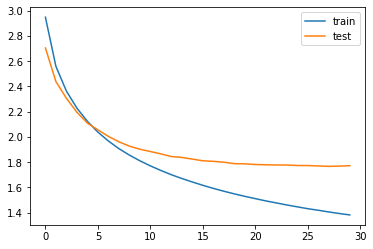

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 테스트 단계(인퍼런스 모델 구현)  
테스트 단계에서 정수 인덱스를 실제 데이터로 복원해야함  
step1. 3개의 사전 준비    
step2. 인퍼런스를 위한 모델을 별도로 설계  
-encoder model, decoder model 분리해서 설계  
step3. 단어 시퀀스를 완성하는 함수  
step4. 모델 테스트 

<b>step1. 3개의 사전 준비</b>  
1. src_index_to_word:원문 단어 집합에서 정수로부터 단어를 얻음  
2. tar_word_to_index:headlines 단어 집합에서 단어로부터 정수를 얻음  
3. tar_index_to_word:headlines 단어 집합에서 정수로부터 단어를 얻음  

In [48]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

<b>step2. encoder 설계</b>

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


<b>step3. decoder 설계</b>

In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


<b>step4. 단어 시퀀스를 완성하는 함수</b>

In [56]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

<b>text와 headlines의 정수 시퀀스를 텍스트 시퀀스로 변환</b>  
seq2text함수: text의 경우 padding인 0을 제외  
seq2headline함수: headlines의 padding인 0과 sostoken(시작토큰), eostoken(종료토큰) 제외

In [57]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

<b>테스트 데이터 약50개의 샘플에 대해 실제 요약과 예측된요약 비교</b>  

In [58]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headline(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : rajkummar rao talking film newton india official entry oscars said wants film break country dry spell oscars campaign trying level best hoping best added rajkummar newton compete films foreign language film category oscars 
실제 요약 : want to break india at rajkummar 
예측 요약 :  rajkummar rao on india entry into


원문 : supreme court tuesday suggested establishment fast track courts trials corrupt mps mlas comes probe income tax department revealed substantial increases assets mps mlas court said inquiry conducted ascertain reason behind increase wealth lawmakers 
실제 요약 : sc fast track for 
예측 요약 :  sc to review assets of mlas in days


원문 : seven people including year old child killed cylinder blast caused part factory building collapse delhi nagar wednesday said police eight others trapped inside rescued taken hospital delhi fire service said building owner obtained objection certificate fire safety place 
실제 요약 : killed after blast factory to collapse in delhi 
예측 요약 :  killed injure

### Discussion  
위의 결과를 쭉 읽어봤는데 실제 요약과 예측 요약에 차이가 많이 났다.  
예를 들어 실제 요약이 bigg boss he is kin family 이고 예측 요약이 fir against son for son인데  
예측 요약이 단어의 어순이 문법적으로 맞지 않고 실제 요약에서 한번만 사용됐던 단어가 두번 중복되었다.  
신문기사 제목을 보면 대강 그 기사의 내용을 예측할 수 있는데 이렇게 되면 신문 기사의 내용이 무엇일지 추측하기 어렵다.  
모델에 많은 수정이 필요해 보인다.  
아래는 더 나은 모델을 만드는 방안 몇 개를 수록했다.  
  
#### 더 나은 모델을 만드는 방법  
1. seq2seq와 attention 조합 좀 더 좋게 수정  
2. 빔서치(beam search)  
3. 사전 훈련된 워드 임베딩(pre-trained word embedding)  
4. 인코더 디코더 자체 구조를 새로인 변경한 트랜스포머(transformer)등 새로운 방안이 있음  

## 추출적 요약  
summa 패키지에 있는 summarize 모듈 사용해 신문기사 추출적 요약해보기  
summarize 모듈은 문장 토큰화를 별도로 하지 않아도 내부적으로 문장 토큰화 사용  
  
필요한인자  
text (str) : 요약할 테스트  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수  
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다  
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환  
  
신문기사 데이터는 이미 위에서 데이터 전처리를 거친 data['text]와 data['headlines']를 사용  

In [13]:
from summa.summarizer import summarize

In [14]:
#데이터 다시 불러오기 
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text2 = data['text']

In [20]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 50:
        break
    print("원문 :", text)
    print("실제 기사제목 :", head)
    print("예측 기사제목 :", summarize(text, ratio=0.40, words=20))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 기사제목 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 기사제목 : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.

### Discussion  
데이터 전처리를 거치지 않은 raw data를 그대로 text로 넘겨줬다.  
결과를 보니 예측 요약이 아예 나오지 않은 것도 있었는데 이유는 모르겠다.  
예측요약을 보니 대체로 text의 마지막 문장을 그대로 가지고 온 경우가 많아 headline을 제대로 예측한건지 의문스럽다.  
전처리 과정과 모델 설계 과정이 복잡하지만 추상적 요약 방식이 더 신문기사 제목을 예측하자는 우리의 의도에 맞는 방법인 것 같다.  
추상적 요약 방식은 결과가 문법상 오류가 많았고 의미 전달이 거의 안된다는 단점이 있었으나 이는 모델 설계를 더 정밀하게 하거나 데이터 전처리로 극복할 수 있어 보인다.  
반면서 추출적 요약은 개선할 수 있는 부분에 제약이 있어 성능을 올리는데 한계가 있을 수 있다.  
아마도 summa 패키지 보다 더 좋은 패키지가 있다면 더 나은 결과가 나타날 것이다.  